## **Packages installation :**

The swifter package is used to fasten our calculcation by parallelizing our processes that used the apply function from pandas

In [ ]:
!pip install swifter

     |████████████████████████████████| 634kB 5.6MB/s 
     |████████████████████████████████| 471kB 28.3MB/s 
     |████████████████████████████████| 542kB 39.6MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 23.1MB 53.4MB/s 
     |████████████████████████████████| 17.2MB 137kB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 2.9MB 43.0MB/s 
     |████████████████████████████████| 204kB 53.1MB/s 
     |████████████████████████████████| 1.3MB 42.6MB/s 
     |████████████████████████████████| 133kB 38.1MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 143kB 46.4MB/s 
     |████████████████████████████████| 296kB 42.3MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
  Created wheel for swifter: filename=swifter-1.0.7-cp36

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Paths :**

In [ ]:
#input_file_path path to the folder containing the test and train sets
input_file_path = "/content/drive/MyDrive/M2 MLDS/Documents  et cours/Fact/Results/"
#output_file_path path for saving the Baseline results

output_file_path = "/content/drive/MyDrive/M2 MLDS/Documents  et cours/Fact/Results/parameters/SVDplusplus/"

In [ ]:
import pandas as pd
import numpy as np
import math
import pickle
import swifter
import matplotlib.pyplot as plt

## **Functions :**

In [ ]:
"""
Functions used to save object such as: dictionnaries (user and asset dictionnaries)
- Input:
obj: object to save
name: output filte name
path: path to the saving directory

"""
def save_obj(obj, name, path):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
"""
load_obj:
- Input:
name: input filte name
path: path to the loading directory
- Output:
the loaded object
"""
def load_obj(name, path):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## **Loading data :**

In [ ]:
interest_train = pd.read_csv(input_file_path + "interest_train.csv", index_col="index")
interest_test = pd.read_csv(input_file_path + "interest_test.csv", index_col="index")

In [ ]:
#we reset indexes to be able to extract mini batches using rows indexes
interest_train.reset_index(inplace=True, drop=True)
interest_test.reset_index(inplace=True, drop=True)


In [ ]:
interest_train

,id_profile,id_asset,rating,fui,rui
0,326534,202094,NaN,0.0,0.0
1,133318,5343689,NaN,0.0,0.0
2,1101174,86739,NaN,0.0,1.0
3,1264136,5349884,NaN,0.0,0.0
4,1093487,1547,NaN,0.0,0.0
...,...,...,...,...,...
51560975,221051,5300969,NaN,0.0,0.0
51560976,1688358,6635718,NaN,0.0,0.0
51560977,335210,4866597,NaN,0.0,0.0
51560978,614980,435552,NaN,0.0,0.0


## **setting up parameters :**

For the average rating calculation we decided to only keep the non null ratings, doing so give a more relevant rating than taking evry row into account (which gave us an average rating close to 0).<br>
We set up an index for each user and asset, that we save into dictionnaries. Those indexes will be used to keep track of each **user bu** and **each asset bi**.
 

In [ ]:
# mu is the overall average rating,
mu = interest_train[~interest_train["rating"].isnull()]["rating"].mean()

# getting unique users and assets from the train set
unique_users = interest_train["id_profile"].unique()
unique_assets = interest_train["id_asset"].unique()

#keeping track of number of: users, n_asset, n_rows of traing set
n_users = len(unique_users)
n_asset = len(unique_assets)
n_rows = len(interest_train)


#getting the users and assets indexes as dictionnaries
idx_users = {y: x for x,y in enumerate(unique_users)}
idx_assets = {y: x for x,y in enumerate(unique_assets)}

#saving the dictionnaries of indexes and average rating
save_obj(idx_users, "idx_users", output_file_path)
save_obj(idx_assets, "idx_assets", output_file_path)
np.save(output_file_path + "/mu.npy", mu)

#setting the batch size, if experiencing ram shortage try reducing batch size
BATCH_SIZE = 512


## **SVD++ class :**
We chose to implement the **SVD++** model through a class that contain several method to keep our work well organized.<br>

As mentionned in the original paper, a popular approach consist of an svd like lower rank decomposition of the original rating matrix where each user u is associated with a user factor vector **pu** and each item i with an item factor vector **qi**.<br>
This bring us our first equation of prediction for SVD decomposition which is :

\begin{equation}
\hat{r}{ui} = b{ui} + p_u^T q_i.
\end{equation}

but such prediction only take into account explicit feedbacks (user ratings), and does not use implicit feedbacks informations (user favorites). As specified in the original paper we can integrate such implicit feedback to get more accurate results by a direct modification of the previous SVD equation :
  
\begin{equation}
\hat{r}_{ui} = b_{ui} + q_i^T \left( p_u  +  \frac{1}{\sqrt{ | \mbox{N}(u) |}}\sum_{j \in \mbox{N}(u)} y_j \right).
\end{equation}

Now a user u is modeled as:

\begin{equation}
p_u  +  \frac{1}{\sqrt{ | \mbox{N}(u) |}}\sum_{j \in \mbox{N}(u)} y_j .
\end{equation}

where **pu** is a free user factor vector which would be learned using explicit feedbacks and complemented by the implicit feedbacks vecotors **Yj**. This brings us our final model **SVD++**.

The parameters **Bu, Bi** ans parameter vectors **Qi, Pu, Yj** are the parameters that we have to train using the following loss function :

\begin{equation}
\sum_{(u,i) \in \mathcal{K}} (r_{ui} - \hat{r}_{ui} )^2 + \lambda \left( \sum_{u} b_u^2 + \sum_{i} b_i^2  + ||p_u||^2 + ||q_i||^2 + ||y_j||^2 \right),
\end{equation}

To minimize the loss we used mini batch gradient descent method as a way to optimize memory consumption and fasten calculation. Bellow the derivative with respect to each parameter :<br>
Bu derivative :

\begin{equation}
\sum_{(i) \in \mathcal{R(u)}} -2* (r_{ui} - \hat{r}_{ui}) + 2* \lambda ( b_u ),
\end{equation}

Bi derivative :

\begin{equation}
\sum_{(u) \in \mathcal{W(i)}} -2* (r_{ui} - \hat{r}_{ui}) + 2* \lambda ( b_i ),
\end{equation}

Qi derivative :

\begin{equation}
\sum_{(u) \in \mathcal{W(i)}} -2* (p_u +(\frac{\sum_{j \in \mbox{N}(u)} y_j}{\sqrt{ | \mbox{N}(u) |}} )  )  (r_{ui} -\hat{r}_{ui}) + 2* \lambda( q_i ),
\end{equation}


Pu derivative :

\begin{equation}
\sum_{(i) \in \mathcal{R(u)}} -2* (q_i) (r_{ui} -\hat{r}_{ui}) + 2* \lambda( p_u ),
\end{equation}



Yj derivative :

\begin{equation}
\sum_{(u) \in \mathcal{S(j)}} \sum_{(i) \in \mathcal{R(u)}} -2* (\frac{q_i}{\sqrt{ | \mbox{N}(u) |}} ) (r_{ui} - \hat{r}_{ui}) + 2* \lambda ( y_j) ,
\end{equation}

Here R(u) is the set of item rated by user u and W(i) is the set of user that rated the item i. <br> 
N(u) : set of movies for which  u  provided an implicit preference. <br>
S(j) ; set of user that have movie j as favorite. <br>

In our final implementation we vectorized the derivatives calculation which means that we calculate the gradient with respect to the loss function for each mini batch of bu and bi parameters that were found in mini batch row.







In [ ]:
class SVDplusplus:
  """
  Init function to initialize the baseline estimate object
  - Input:
  train_dataset: training dataset
  mu: average rating
  idx_users: dictionnary containing user indexes
  idx_assets: dictionnary containing asset indexes
  Bi: (Optionnal) assets weights should be of same size as number of unique assets, default None will be initialized to random at training 
  Bu: (Optionnal)  users weights should be of same size as number of unique users, default None will be initialized to random at training,
  Pu: (Optionnal)  users factor vectors should be of size (number of unique users * nb_factor), default None will be initialized to random at training,
  Qi: (Optionnal)  asset factor vectors should be of size (number of unique assets* nb_factor), default None will be initialized to random at training,
  Yj: (Optionnal)  implicit feedbacks vectors should be of (number of unique assets* nb_factor), default None will be initialized to random at training,  
 
  losses: (Optionnal) keep track of loss initialized at []
  BATCH_SIZE: (Optionnal)
  seed:(Optionnal) to keep same results

  """
  def __init__(self, train_dataset, mu,idx_users, idx_assets, Bi = None, Bu = None,Qi = None, Pu = None, Yj = None,
               losses= [], BATCH_SIZE=2048,seed=123):
    np.random.seed(seed)
    self.BATCH_SIZE = BATCH_SIZE
    self.train_dataset = train_dataset
    self.Bu = Bu
    self.Bi = Bi
    self.Qi = Qi
    self.Pu = Pu
    self.Yj = Yj
    self.mu = mu
    self.losses = losses
    # counting the number of rows 
    self.n_rows = train_dataset.shape[0]
    # counting the number of batches
    self.n_batches = math.ceil(self.n_rows/BATCH_SIZE)
    self.idx_users = idx_users
    self.idx_assets = idx_assets


    """
  Train function to train the baseline model
  - Input:
  epochs: number of epochs 
  path_to_file: (optionnal) if set it will save parameters and loss in the specified directory path
  save_every: (optionnal) if path_to_file is set, save_every indicates the epochs saving frequency
  lr: (optionnal) learning rate
  reg_lambda: (optionnal) regularization term
  current_epoch: (optionnal) if we want to resume training using loaded weights.
  n_factors: (optionnal) if we want to set the number of factors default = 50.
  -Output:
  losses: list of loss per epoch
  """
  def train(self, epochs,path_to_file = "", current_epoch=1, lr = 0.009, reg_lambda = 0.04, save_every=2, n_factors=50):
    if(self.Bu is None):
      self.Bu = np.random.normal(0,  0.2, size=n_users).astype(np.float32)
    if(self.Bi is None):
      self.Bi = np.random.normal(0, 0.2, size=n_asset).astype(np.float32)
    if(self.Qi is None):
      self.Qi = np.random.normal(0,  0.2, size=(n_asset, n_factors)).astype(np.float32)
    if(self.Pu is None):
      self.Pu = np.random.normal(0, 0.2, size=(n_users, n_factors)).astype(np.float32)
    if(self.Yj is None):
      self.Yj = np.random.normal(0, 0.2, size=(n_asset, n_factors)).astype(np.float32)

    rui = np.asarray(self.train_dataset["rui"])
    mu = self.mu
    
    self.losses = []

    for i in range(current_epoch-1, epochs):
      print("")
      print("-------------------------------------")
      print("EPOCH :", i+1)
      self.Bu, self.Bi, self.Qi, self.Pu, self.Yj = self.compute_one_epoch(self.Bu,self.Bi,self.Qi, self.Pu, self.Yj,
                                                self.BATCH_SIZE,self.n_batches,
                                                self.train_dataset, self.mu,reg_lambda,lr)
      print("")
      print("computing loss : ")
      
      loss, reg_loss = self.compute_loss(self.Bu, self.Bi,self.Qi, self.Pu, self.Yj, self.BATCH_SIZE, self.n_batches, self.train_dataset, self.mu)
      print("")
      print("Current epoch loss :", loss, "regularized_loss :", reg_loss)
      self.losses.append(reg_loss)
      if((i + 1)%save_every == 0):
        if(path_to_file):
          #saving parameter bi, bu, qi, pu, yj and losses
          np.save (path_to_file + "bi_" + str(i+1) + ".npy",self.Bi)
          np.save(path_to_file + "bu_" + str(i+1) + ".npy", self.Bu)
          np.save (path_to_file + "qi_" + str(i+1) + ".npy",self.Qi)
          np.save (path_to_file + "pu_" + str(i+1) + ".npy",self.Pu)
          np.save(path_to_file + "yj_" + str(i+1) + ".npy", self.Yj)
          np.save(path_to_file + "losses.npy", self.losses)    
    return self.losses

    """
  compute_loss: used to compute loss.

  - Input:
  Bu:(Optionnal) Bu parameters if set up to None will use the object intialized parameter
  Bi:(Optionnal) Bi parameters if set up to None will use the object intialized parameter
  Pu: (Optionnal) Pu parameters if set up to None will use the object intialized parameter
  Qi: (Optionnal) Qi parameters if set up to None will use the object intialized parameter
  Yj: (Optionnal) Yj parameters if set up to None will use the object intialized parameter 
  BATCH_SIZE:(Optionnal) batch size if set up to None will use the object intialized parameter
  n_batches:(Optionnal) number of batches if set up to None will use the object intialized parameter
  n_rows:(Optionnal) number of rows if set up to None will use the object intialized parameter
  dataset:(Optionnal) as a pandas dataframe if set up to None will use the object intialized parameter
  mu:(Optionnal) average rating if set up to None will use the object intialized parameter
  reg_lambda: (optionnal) regularization 
  dataset_percent: (optionnal) percent of the given data set that will be used to compute loss, 1 = 100%

  -Output:
  no_reg_loss: loss without regularization
  loss_regularized: regularized loss
  """
  def compute_loss(self, Bu=None,Bi=None,Qi=None, Pu=None, Yj=None,BATCH_SIZE=None,n_batches=None,dataset=None, mu=None,reg_lambda = 0.02,dataset_percent=0.1):
    # parameter initialization
    if (dataset is None):
      dataset=self.train_dataset
      BATCH_SIZE= self.BATCH_SIZE
      n_batches= self.n_batches
      n_rows= self.n_rows
    else:
      if (BATCH_SIZE == None):
        BATCH_SIZE = self.BATCH_SIZE

      n_rows = dataset.shape[0]
      n_batches = math.ceil(n_rows/BATCH_SIZE)
      
      
      
    if (mu == None):
      mu= self.mu

    if (Bu is None):
      Bu= self.Bu
    if (Bi is None):
      Bi= self.Bi
    if (Qi is None):
      Qi= self.Qi
    if (Pu is None):
      Pu= self.Pu
    if (Yj is None):
      Yj= self.Yj


    shuffled_idx = np.asarray(dataset.index)

    n_rows = len(shuffled_idx)

    # number of sample initialization will be incremanted for each row used in the minibatch computation
    n_sample = 0

    # For regularization
    Bu_pow_sum = sum(np.power(Bu,2))
    Bi_pow_sum = sum(np.power(Bi,2))
    Qi_norm_pow_sum = np.power(np.linalg.norm(Qi, axis = 1),2).sum()
    Pu_norm_pow_sum = np.power(np.linalg.norm(Pu, axis = 1),2).sum()
    Yj_norm_pow_sum = np.power(np.linalg.norm(Yj, axis = 1),2).sum()

    loss = 0
    # iterating over all batches to compute one epoch
    for i in range(math.floor(n_batches*dataset_percent)):
      start = i*BATCH_SIZE
      end = (i + 1)*BATCH_SIZE
      if end > n_rows:
        end = n_rows
      # extract one mini batch
      sub_df = dataset.iloc[shuffled_idx[start:end]]
      n_sample += sub_df.shape[0]

      #creating an rui pivot matrix of size ( number of uniqueUsers in mini batch * number of uniqueAssets in mini batch)
      pivot_df = sub_df.pivot(index='id_profile', columns='id_asset', values='rui')
      pivot_array = pivot_df.to_numpy()
      #creating a pivot favorites matrix of size ( number of uniqueUsers in mini batch * number of uniqueAssets in mini batch)
      #to keep track of which movies is favorited by each user (1 else 0)      
      pivot_fav = sub_df.pivot(index='id_profile', columns='id_asset', values='fui')

      fav_array = pivot_fav.to_numpy()
      fav_array[fav_array == 5] = 1





      #sub_u id (id_profile) of each user contained in the minibatch
      sub_u = pivot_df.index.to_numpy()
      #sub_i id (id_asset) of each asset contained in the minibatch
      sub_i = pivot_df.columns.to_numpy()

      #extracting the related index of each user
      bu_idx = np.asarray([self.idx_users[x] for x in sub_u])
      #extracting the related index of each asset
      bi_idx = np.asarray([self.idx_assets[x] for x in sub_i])


      #extracted the related Bu weight of each user that will be optimized during this mini batch computation
      sub_bu = Bu[bu_idx]
      #extracted the related Bi weight of each asset that will be optimized during this mini batch computation
      sub_bi = Bi[bi_idx]
      #extracted the related Qi weight of each asset that will be optimized during this mini batch computation
      sub_qi = Qi[bi_idx]
      #extracted the related Pu weight of each user that will be optimized during this mini batch computation
      sub_pu = Pu[bu_idx]
      
      #favorite weights that will be optimized during this mini batch computation
      sub_yj = Yj[bi_idx]

      #Creating the rui matrix from the pivot array mini batch
      bubi_rui = np.nan_to_num(pivot_array)

      #Creating the bubi_found matrix that would be used to only take into account known comnination of user and asset in the minibatch
      # if user asset combination is found = 1 else 0
      bubi_found = pivot_array
      bubi_found[~np.isnan(bubi_found)] = 1
      bubi_found = np.nan_to_num(bubi_found)
      # removing non from favorites pivot matrix
      fav_array = np.nan_to_num(fav_array)

      #calculating bui for each (user, asset) combination same as baseline estimate model (when computing loss)
      bui_mat = bubi_found.copy()

      bui_mat[bui_mat == 1] = mu
      bui_mat = bui_mat + sub_bu[:, None]

      bui_mat = bui_mat + sub_bi

      #sum of all movies favorited for each user
      sum_Nu = fav_array.sum(1)
      
      sum_Nu = np.sqrt(sum_Nu)
      # this is done to avoid divinding by 0
      sum_Nu[sum_Nu != 0] = 1 / sum_Nu[sum_Nu != 0]

      # sum of yj favorited by each user and weighted by sum_nu, size(number of unique user on minibatch* number of factors)
      sum_yj = fav_array.dot(sub_yj) * sum_Nu[:, None]
      
      # qiT * sum_yj
      u_qi_yj = sum_yj.dot(sub_qi.T)

      #Result of predicted rui (bui + qiT(pu+sumyj/Nu))
      bui_mat += sub_pu.dot(sub_qi.T) + u_qi_yj

      #computing loss for each user
      rui_bui = np.power((bubi_rui - bui_mat),2)
      #setting loss to 0  all the non existing (user,asset) combination (that should not be taken into account) 
      rui_bui[bubi_found == 0] = 0      
      #adding the loss to the overall loss
      loss += rui_bui.sum()

      
      if(i%(math.ceil(n_batches*0.1*dataset_percent)) == 0):
        print(str(math.floor(100*i/(n_batches*dataset_percent))),"% treated")
    
    no_reg_loss = loss/n_sample
    loss_regularized = (loss + reg_lambda*(Bu_pow_sum + Bi_pow_sum + Qi_norm_pow_sum + Pu_norm_pow_sum + Yj_norm_pow_sum))/n_sample
    return no_reg_loss, loss_regularized

  """
  Compute_one_epoch: used to compute one epoch of training on all the dataset

  - Input:
  Bu: Bu parameters that will be updated 
  Bi: Bi parameters that will be updated
  Pu: Pu parameters that will be updated 
  Qi: Qi parameters that will be updated 
  Yj: Yj parameters that will be updated 
  
  BATCH_SIZE: batch size
  n_batches: number of batches
  n_rows: number of rows
  dataset: training dataset as a pandas dataframe
  mu: average rating
  reg_lambda: (optionnal) regularization parameter
  lr: (optionnal) learning rate

  -Output:
  Bu: updated Bu
  Bi: updated Bi
  Pu: updated Pu
  Qi: updated Qi
  Yj: updated Yj
  """
  def compute_one_epoch(self, Bu,Bi, Qi, Pu, Yj,BATCH_SIZE,n_batches,dataset, mu,reg_lambda = 0.02,lr=0.02):
    # shuffle the index on each new epoch
    shuffled_idx = np.asarray(dataset.index)

    np.random.shuffle(shuffled_idx)

    
    n_rows = len(shuffled_idx)
    # iterating over all batches to compute one epoch
    for i in range(n_batches):
      start = i*BATCH_SIZE
      end = (i + 1)*BATCH_SIZE
      if end > n_rows:
        end = n_rows

      # extract one mini batch
      sub_df = dataset.iloc[shuffled_idx[start:end]]

      #creating an rui pivot matrix of size ( number of uniqueUsers in mini batch * number of uniqueAssets in mini batch)
      pivot_df = sub_df.pivot(index='id_profile', columns='id_asset', values='rui')
      pivot_array = pivot_df.to_numpy()

      #creating a pivot favorites matrix of size ( number of uniqueUsers in mini batch * number of uniqueAssets in mini batch)
      #to keep track of which movies is favorited by each user (1 else 0)
      pivot_fav = sub_df.pivot(index='id_profile', columns='id_asset', values='fui')

      fav_array = pivot_fav.to_numpy()
      fav_array[fav_array == 5] = 1





      #sub_u id (id_profile) of each user contained in the minibatch
      sub_u = pivot_df.index.to_numpy()
      #sub_i id (id_asset) of each asset contained in the minibatch
      sub_i = pivot_df.columns.to_numpy()

      #extracting the related index of each user
      bu_idx = np.asarray([self.idx_users[x] for x in sub_u])
      #extracting the related index of each asset
      bi_idx = np.asarray([self.idx_assets[x] for x in sub_i])


      #extracted the related Bu weight of each user that will be optimized during this mini batch computation
      sub_bu = Bu[bu_idx]
      #extracted the related Bi weight of each asset that will be optimized during this mini batch computation
      sub_bi = Bi[bi_idx]
      #extracted the related Qi weight of each asset that will be optimized during this mini batch computation
      sub_qi = Qi[bi_idx]
      #extracted the related Pu weight of each user that will be optimized during this mini batch computation
      sub_pu = Pu[bu_idx]
      
      #favorite weights that will be optimized during this mini batch computation
      sub_yj = Yj[bi_idx]
      
      #Creating the rui matrix from the pivot array mini batch
      bubi_rui = np.nan_to_num(pivot_array)
      #Creating the bubi_found matrix that would be used to only take into account known comnination of user and asset in the minibatch
      # if user asset combination is found = 1 else 0
      bubi_found = pivot_array
      bubi_found[~np.isnan(bubi_found)] = 1
      bubi_found = np.nan_to_num(bubi_found)
      # removing non from favorites pivot matrix
      fav_array = np.nan_to_num(fav_array)

      #calculating bui for each (user, asset) combination same as baseline estimate model (when computing loss)
      bui_mat = bubi_found.copy()

      bui_mat[bui_mat == 1] = mu

      bui_mat = bui_mat + sub_bu[:, None]
      bui_mat = bui_mat + sub_bi

      #sum of all movies favorited for each user
      sum_Nu = fav_array.sum(1)
      
      sum_Nu = np.sqrt(sum_Nu)
      # this is done to avoid divinding by 0
      sum_Nu[sum_Nu != 0] = 1 / sum_Nu[sum_Nu != 0]
      
      # sum of yj favorited by each user and weighted by sum_nu, size(number of unique user on minibatch* number of factors)
      sum_yj = fav_array.dot(sub_yj) * sum_Nu[:, None]
      
      # qiT * sum_yj
      u_qi_yj = sum_yj.dot(sub_qi.T)

      #Result of predicted rui (bui + qiT(pu+sumyj/Nu))
      bui_mat += sub_pu.dot(sub_qi.T) + u_qi_yj

      rui_bui = -2 * (bubi_rui - bui_mat)
      #setting to 0  all the non existing (user,asset) combination (that should not be taken into account) 
      rui_bui[bubi_found == 0] = 0

      #sum of i of  -2 * (rui-ruihat) for each user size(number of unique users in mini batch)
      user_ruibui_sum = rui_bui.sum(1)
      #sum of u of  -2 * (rui-ruihat) for each asset size(number of unique assets in mini batch)
      asset_ruibui_sum = rui_bui.sum(0)
      rui_bui_T = rui_bui.T

      rb_dot_qi = rui_bui.dot(sub_qi) * sum_Nu[:, None]






      #computing gradient
      bu_grads = user_ruibui_sum + 2*reg_lambda*sub_bu

      bi_grads = asset_ruibui_sum + 2*reg_lambda*sub_bi

      qi_grads = rui_bui_T.dot(sub_pu) + rui_bui_T.dot(sum_yj) + 2*reg_lambda*sub_qi

      pu_grads = rui_bui.dot(sub_qi) + 2*reg_lambda*sub_pu

      yj_grads = fav_array.T.dot(rb_dot_qi) + 2*reg_lambda*sub_yj

      bu_next = sub_bu - lr*bu_grads

      bi_next = sub_bi -lr*bi_grads

      qi_next = sub_qi - lr*qi_grads

      pu_next = sub_pu -lr*pu_grads

      yj_next = sub_yj -lr*yj_grads





      #updating parameters using the indexes 
      Bu[bu_idx] = bu_next

      Bi[bi_idx] = bi_next

      Qi[bi_idx] = qi_next

      Pu[bu_idx] = pu_next

      Yj[bi_idx] = yj_next




      if(i%(math.ceil(n_batches*0.1)) == 0):
        print(str(math.floor(100*i/n_batches)),"% treated")
      

    return Bu, Bi, Qi, Pu, Yj




## **load model :**

In [ ]:
be = SVDplusplus(interest_train,mu,idx_users,idx_assets, BATCH_SIZE=BATCH_SIZE)

## **train and save model :**

In [ ]:
# train for 10 epochs
be.train(path_to_file=output_file_path,epochs=10,save_every=1)


-------------------------------------
EPOCH : 1
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

computing loss : 
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

Current epoch loss : 0.9397213224731146 regularized_loss : 0.9860830505464143

-------------------------------------
EPOCH : 2
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

computing loss : 
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

Current epoch loss : 0.5176476762189591 regularized_loss : 0.566917889575791

-------------------------------------
EPOCH : 3
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

computing lo

[0.9860830505464143,
 0.566917889575791,
 0.41573054415384597,
 0.3419952974312377,
 0.2992889269883516,
 0.2697968131951735,
 0.2496090279404721,
 0.23426379682115933,
 0.22279310111565473,
 0.21247469666737795]

In [ ]:
#train for 10 more epoch starting from current_epoch=11

be.train(path_to_file=output_file_path,epochs=20,save_every=1,current_epoch=11,lr=0.005)


-------------------------------------
EPOCH : 11
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

computing loss : 
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

Current epoch loss : 0.14508715814627485 regularized_loss : 0.2013733796400085

-------------------------------------
EPOCH : 12
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

computing loss : 
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

Current epoch loss : 0.1417623025167972 regularized_loss : 0.19820914286343344

-------------------------------------
EPOCH : 13
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

comput

[0.2013733796400085,
 0.19820914286343344,
 0.1932928126629423,
 0.1903718991846768,
 0.18571320529976568,
 0.18278150893219855,
 0.179248156508314,
 0.17707363327642622,
 0.17382391291004295,
 0.171745226824108]

## **test model :**

In [ ]:
test_loss = []
mu = np.load(output_file_path + "/mu" + ".npy")
BATCH_SIZE=512
idx_users = load_obj("/idx_users", output_file_path)
idx_assets = load_obj("/idx_assets",output_file_path)

for i in range(20):
  print("test EPOCH " + str(i+1))
  Bu = np.load(output_file_path + "/bu_" + str(i+1) + ".npy")
  Bi = np.load(output_file_path + "/bi_" + str(i+1) + ".npy")
  Qi = np.load(output_file_path + "/qi_" + str(i+1) + ".npy")
  Pu = np.load(output_file_path + "/pu_" + str(i + 1) + ".npy")
  Yj = np.load(output_file_path + "/yj_" + str(i + 1) + ".npy")
  losses = np.load(output_file_path + "/losses.npy")
  be = SVDplusplus(train_dataset=interest_train, mu=mu, idx_users=idx_users, idx_assets=idx_assets, Bi= Bi,
                 Bu=Bu, Qi=Qi, Pu=Pu,Yj=Yj, losses=losses, BATCH_SIZE=BATCH_SIZE)
  no_reg_loss, loss_regularized = be.compute_loss(dataset=interest_test, dataset_percent=1)
  loss.append(loss_regularized)

np.save(output_file_path + "/test_losses.npy", loss)

test EPOCH 1
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 2
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 3
0 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 4
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 5
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 6
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 7
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 8
0 % tr

In [ ]:
idx_users = load_obj("/idx_users", output_file_path)
idx_assets = load_obj("/idx_assets",output_file_path)

## **Plot test and train loss on each epoch :**

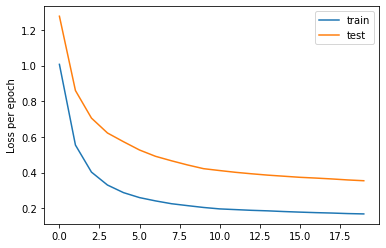

In [ ]:
import matplotlib.patches as mpatches
import numpy as np
test_loss = np.load(output_file_path + "/test_losses.npy").tolist()
loss = np.load(output_file_path + "/losses.npy").tolist()


plt.plot(loss, label="train")
plt.plot(test_loss, label="test")
plt.ylabel('Loss per epoch')
plt.legend()
plt.show()


In [ ]:
bestResult_Index = np.argmin(loss) + 1
bestResult_MSE_Loss_train = np.min(loss)
bestResult_RMSE_Loss_train = np.sqrt(bestResult_MSE_Loss_train)

print("Best epoch result on train set : {}".format(bestResult_Index))
print("MSE loss on train set : {}".format(bestResult_MSE_Loss_train))
print("RMSE loss on train set : {}".format(bestResult_RMSE_Loss_train))

Best epoch result on train set : 20
MSE loss on train set : 0.16780573617881872
RMSE loss on train set : 0.40964098449595926


In [ ]:
bestResult_Index = np.argmin(test_loss) + 1
bestResult_MSE_Loss_test = np.min(test_loss)
bestResult_RMSE_Loss_test = np.sqrt(bestResult_MSE_Loss_test)

print("Best epoch result on test set : {}".format(bestResult_Index))
print("MSE loss on test set : {}".format(bestResult_MSE_Loss_test))
print("RMSE loss on test set : {}".format(bestResult_RMSE_Loss_test))

Best epoch result on test set : 20
MSE loss on test set : 0.3539570648293017
RMSE loss on test set : 0.594942908882274


## **Exemple of loading a specific epoch parameters :**

In [ ]:
epoch=10

Bu = np.load(output_file_path + "/bu_" + str(epoch) + ".npy")
Bi = np.load(output_file_path + "/bi_" + str(epoch) + ".npy")
Qi = np.load(output_file_path + "/qi_" + str(epoch) + ".npy")
Pu = np.load(output_file_path + "/pu_" + str(epoch) + ".npy")
Yj = np.load(output_file_path + "/yj_" + str(epoch) + ".npy")
losses = np.load(output_file_path + "/losses.npy")
losses= losses[0:epoch]

mu = np.load(output_file_path + "/mu" + ".npy")
BATCH_SIZE=512
idx_users = load_obj("/idx_users", output_file_path)
idx_assets = load_obj("/idx_assets",output_file_path)

be = SVDplusplus(train_dataset=interest_train, mu=mu, idx_users=idx_users, idx_assets=idx_assets, Bi= Bi,
                Bu=Bu, Qi=Qi, Pu=Pu,Yj=Yj, losses=losses, BATCH_SIZE=BATCH_SIZE)

